In [1]:
from models import *
import matplotlib.pyplot as plt
from plotnine import *
import pandas as pd
import numpy as np

<h1> Question 9: </h1>

In this part we will assume a distribution that generates the data points x from a two dimensional Gaussian with mean vector of zeros and a unit matrix for covariance. The true labels are determined by 

What we did in this task was drawing m random points (computer generated) for m in [5, 10, 15, 25, 70] and label them by the function $ f(x) $ above.
Later we computed the different hyperplane classifiers that we built in models.py, and compare between them. In question 8 we were asked to compare the hard-SVM classifier and the perceptron. Here are the results:

In [2]:
pd.set_option('display.max_columns', 5)

def get_hyperplane(w, b, label):
    a = -w[0] / w[1]
    xx = np.linspace(-2.5, 2.5)
    yy = a * xx - (b) / w[1]
    df = pd.DataFrame({'x1': xx, 'x2': yy, 'label': label})
    return df

# question 8
def draw_points(m):
    """
    :param m: number of samples
    :return: X - 2 x m matrix from multivariate gaussian
             y - 1 x m vector of labels according to f(x)
    """
    # set covariance and mean
    cov = np.diag([1, 1])
    mean = np.array([0, 0])
    # randomize X matrix
    X = np.random.multivariate_normal(mean, cov, m).T
    # create w, b
    w, b = np.array([.3, -.5]), 0.1
    # set y by f(x) = sign(<w,x>+b)
    y = np.sign((w @ X) + b)

    return X, y

def create_plot_by_m(m):
    # create data
    X, y = draw_points(m)
    while (y == (-1)).sum() == 0 or (y == 1).sum() == 0:
        X, y = draw_points(m)
    df = pd.DataFrame({'x1': X[0], 'x2': X[1], 'y': pd.Categorical(y)})

    # get real classifier hyperplane
    real_hp = get_hyperplane(np.array([.3, -0.5]), .1, label="Real $ f(x) $")

    # create perceptron and fit
    perceptron = Perceptron()
    perceptron.fit(X, y)

    # get perceptron hyperplane
    perc_hp = get_hyperplane(perceptron.model[1:], perceptron.model[0], label="Perceptron")

    # create SVM classifier and fit
    svm = SVM()
    svm.fit(X, y)

    # get SVM hyperplane
    svm_hp = get_hyperplane(svm.model[1:], svm.model[0], "SVM")

    # plot graph
    g = (ggplot(df) + geom_point(aes(x='x1', y='x2', fill='y'))  # plot points
         + geom_line(mapping=aes(x='x1', y='x2', color='label'),
                     data=pd.concat([perc_hp, real_hp, svm_hp]))  # plot hyperplanes
         + scale_fill_manual(name='Labels', values=["orangered", "blue"])  # set colors
         + scale_color_manual(name="Hyperplane",
                              values={"Real $ f(x) $": "darkgreen", "Perceptron": "darkorange", 'SVM': 'red'})
         + labs(title="HalfSpace Classifiers Comparison with {} samples".format(m)))  # legend

    return g


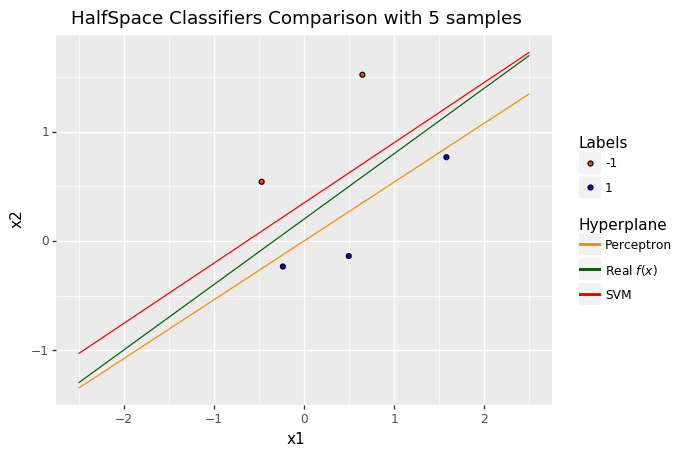

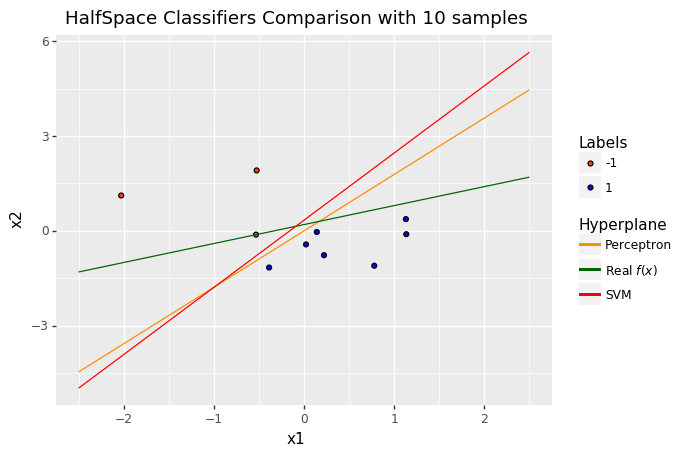

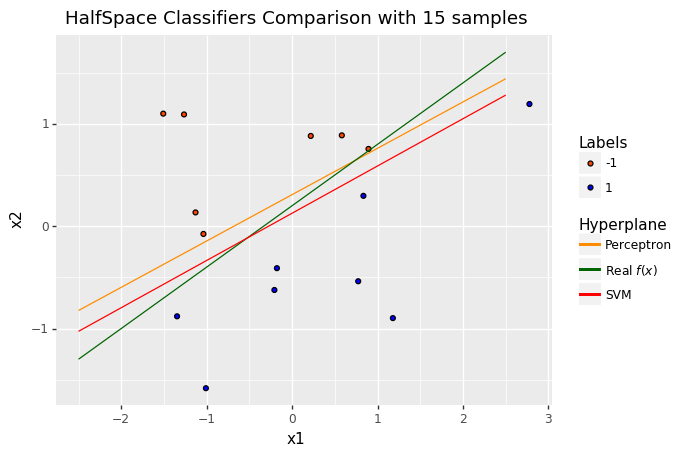

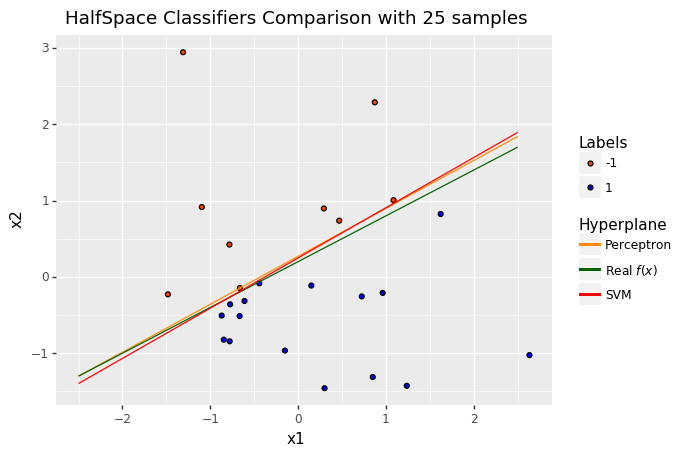

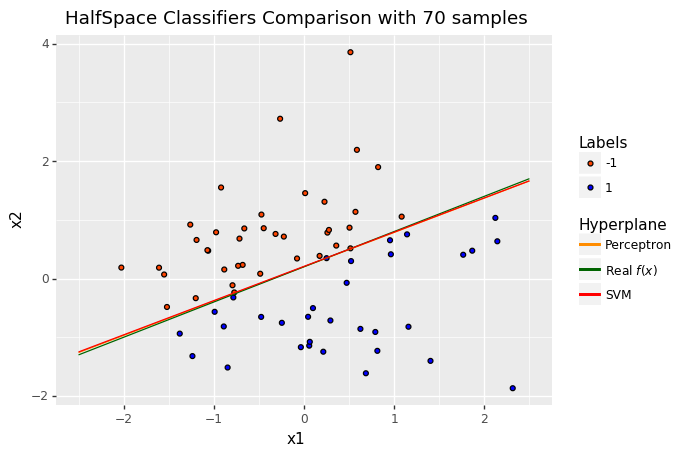

In [3]:
np.random.seed(42)

M = [5, 10, 15, 25, 70]

for m in M:
    g = create_plot_by_m(m)
    g.draw();

It is beautiful to see how the size of our training data impacts the differences between the two classifiers.
We can see that the two classifiers start as very different hyperplanes, and converging as the training set gets bigger.

<h1> Question 10: </h1>

Now, we were asked to create a training set in size m for each m as above, and draw another 10,000 test data points (x,y) and compare the accuracy of the Perceptron classifier, the SVM classifier and the LDA classifier.

We can see the result in the following graph as a function of m:

In [4]:
def single_comparison(m, k):
    X, y_train = draw_points(m)
    while (y_train == (-1)).sum() == 0 or (y_train == 1).sum() == 0:
        X, y_train = draw_points(m)
    Z, y_test = draw_points(k)
    lda, perceptron, svm = LDA(), Perceptron(), SVM()
    classifiers = [lda, perceptron, svm]
    lst_of_acc = []
    for i in range(len(classifiers)):
        classifiers[i].fit(X, y_train)
        accuracy = classifiers[i].score(Z, y_test)['accuracy']
        lst_of_acc.append(accuracy)
    return lst_of_acc


In [5]:
K = 10000
final_dct = {}
for m in M:
    scores = {'lda': [], 'perceptron': [], 'svm': []}
    iters = 500

    for i in range(iters):
        acc_m = single_comparison(m, K)
        scores['lda'].append(acc_m[0])
        scores['perceptron'].append(acc_m[1])
        scores['svm'].append(acc_m[2])

    final_dct[m] = [(k, round(np.mean(v), 3)) for (k, v) in scores.items()]

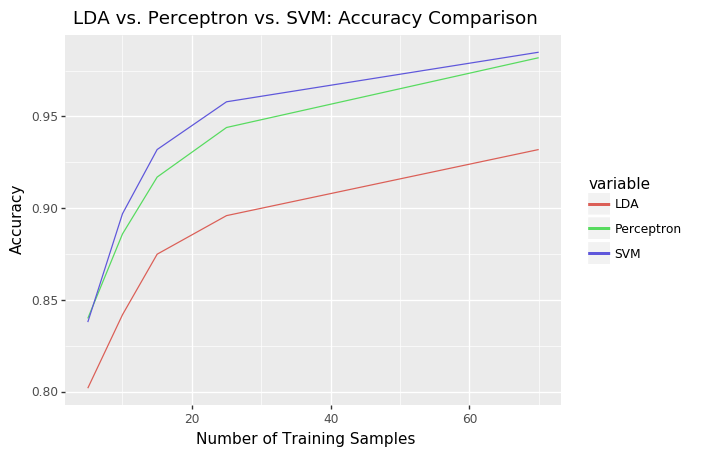

In [6]:
df = pd.DataFrame.from_dict(final_dct, orient='index', columns=['LDA', "Perceptron", "SVM"])
df = df.applymap(lambda x: x[1])
df = df.reset_index().melt(id_vars=['index'])

g = ggplot(df) + geom_line(aes(x='index', y='value', color='variable')) \
+ labs(title="LDA vs. Perceptron vs. SVM: Accuracy Comparison", y='Accuracy', x='Number of Training Samples')
g.draw();


<h1> Question 11: </h1>

We can see that as m grows, so does the accuracy. 
That means that all the classifiers did a better classifiction job with a bigger training data. 

We can see that the hard-SVM was slightly better then the Perceptron, and both of those were way better then the LDA classifier. I think we could expect that, since LDA assumes that the points were from two different distribution, but in reality we had only one. Another thing is that our real classifier was a linear hyperplane that is same as the hypothesis of the SVM and the perceptron (which try to learn and predict this hyperplane), while LDA is a different seperator for linear problems.

I dont have any explaination why the SVM did better than the perceptron, I can just guess that SCIKIT-LEARN might do a better job them me this time. I hope that by the end of the course I'll become a better rival for them.